In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, f1_score, fbeta_score, log_loss
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

# preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [6]:
sepsis_df = pd.read_csv('../sepsis_df.csv')

In [7]:
sepsis_df.info

<bound method DataFrame.info of          HR  O2Sat    SBP    MAP   DBP  Resp    BUN  Calcium  Creatinine  \
0      58.0   95.0  143.0   77.0  47.0  11.0  100.0     7.90        2.50   
1      91.0   94.0  133.0   74.0  48.0  34.0   30.0    10.90        0.90   
2      73.0   99.0  100.0   67.0  49.5  16.5   28.0     7.40        1.20   
3      89.0  100.0  141.0   85.0  57.0  17.0    9.0     8.40        0.70   
4      98.0   94.0   95.0   62.0  45.0  15.0   11.0     7.40        0.50   
...     ...    ...    ...    ...   ...   ...    ...      ...         ...   
16616  74.0   97.0  120.0   72.0  44.0  12.0   14.0     7.50        0.79   
16617  91.0   94.0  136.0   90.0  63.0  21.0   37.0     9.20        9.93   
16618  73.0  100.0  120.0   78.0  58.0  14.5   11.0     4.79        1.13   
16619  59.0   95.0  154.0  110.0  82.0  14.0    9.0     8.80        0.81   
16620  81.0   99.0  122.0   71.0  58.0  20.0    8.0     8.80        0.58   

       Glucose  Potassium   Hct   Hgb   WBC  Platelets 

In [3]:
# create X and y for model
X = sepsis_df.drop(columns=['isSepsis'])
y = sepsis_df.isSepsis

/Users/jasonkim/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='isSepsis', ylabel='count'>

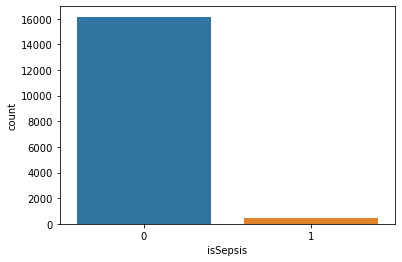

In [5]:
# highly imbalanced dataset!
y.value_counts()
sns.countplot(y)

In [6]:
from collections import Counter
Counter(y)

Counter({0: 16156, 1: 465})

In [10]:
Counter(y)[1]/Counter(y)[0]

0.028781876702154

### Logistic Regression w/ All Features

In [11]:
# splitting data into Train, Val, & Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Random Oversampling:

In [12]:
# resampling using random oversampling
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)

X_train, y_train = ros.fit_resample(X_train,y_train)

/Users/jasonkim/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='isSepsis', ylabel='count'>

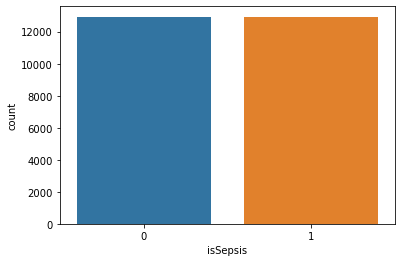

In [13]:
sns.countplot(y_train)

In [14]:
Counter(y_train)

Counter({0: 12933, 1: 12933})

Scaling Features:

In [15]:
# scaling train and test sets
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [17]:
logit = LogisticRegression(C=1000)
logit.fit(X_train_scaled, y_train)
logit_y_pred = logit.predict(X_test_scaled)
logit_confusion = confusion_matrix(y_test, logit_y_pred)

In [19]:
logit_score = logit.predict_proba(X_test_scaled)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, logit_score)
roc_auc = auc(fpr, tpr)

In [20]:
print(classification_report(y_test, logit_y_pred))

              precision    recall  f1-score   support

           0       0.99      0.53      0.69      3223
           1       0.06      0.87      0.10       102

    accuracy                           0.54      3325
   macro avg       0.52      0.70      0.40      3325
weighted avg       0.96      0.54      0.67      3325



In [33]:
def scores(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    fbeta = fbeta_score(y_true, y_pred, beta=2)
    roc_auc = roc_auc_score(y_true, y_pred)

    print(f'Accuracy score: {accuracy}')
    print(f'Precision score: {precision}')
    print(f'Recall: {recall}')
    print(f'F1: {f1}')
    print(f'F-beta (beta=2): {fbeta}')
    print(f'ROC-AUC: {roc_auc}')

In [34]:
scores(y_test, logit_y_pred)

Accuracy score: 0.5389473684210526
Precision score: 0.05531385954008701
Recall: 0.8725490196078431
F1: 0.10403272939801285
F-beta (beta=2): 0.22062469013386218
ROC-AUC: 0.7004693593230031


In [24]:
def make_confusion_matrix(model, threshold=0.5):
    y_predict = (model.predict_proba(X_test_scaled)[:, 1] >= threshold)
    sepsis_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(sepsis_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['No Sepsis', 'Sepsis'],
           yticklabels=['No Sepsis', 'Sepsis']);
    plt.xlabel('prediction')
    plt.ylabel('actual')
    plt.title('Logistic Regression confusion matrix');

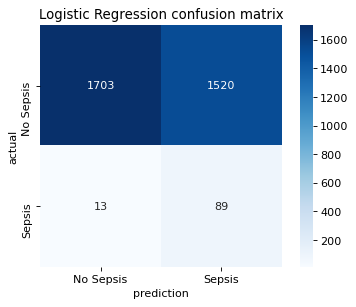

In [25]:
make_confusion_matrix(logit)

### ROC Curve

ROC AUC score =  0.8390003224373833


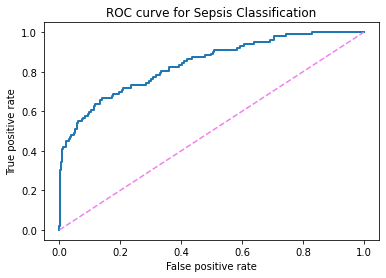

In [30]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for Sepsis Classification');
print("ROC AUC score = ", roc_auc_score(y_test, logit.predict_proba(X_test_scaled)[:,1]))

### Precision & Recall Curves

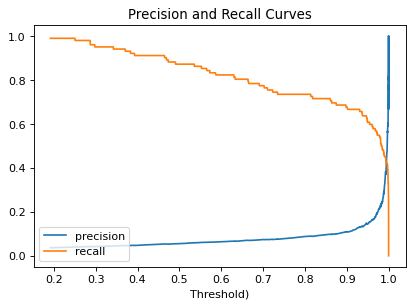

In [39]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, logit.predict_proba(X_test_scaled)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold)');
plt.title('Precision and Recall Curves');